# Data Structuring and Pruning

In [1]:
# Load datasets

import json
import pathlib
import importlib
from collections import defaultdict, Counter
import pyupset as pyu
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import re
from matplotlib.gridspec import GridSpec
import csv
import requests

from vicckb import model as viccdb
from vicckb.definitions import DATA_ROOT
%matplotlib inline

FIGPATH = pathlib.Path('/Users/awagner/Google Drive/VICC/Manuscript/Figures')

In [2]:
# reload module and load data
importlib.reload(viccdb)
vdb = viccdb.ViccDb()
vdb.report_groups()

cgi: 1073 (6.3% of total)
civic: 3340 (19.8% of total)
jax: 5754 (34.0% of total)
molecularmatch: 2085 (12.3% of total)
oncokb: 4048 (24.0% of total)
pmkb: 600 (3.6% of total)
16900 total associations


In [3]:
# for now, omit brca from analysis
brca = vdb.select(lambda x: x['source'] == 'brca')
core_vdb = vdb - brca
core_vdb.report_groups()

cgi: 1073 (6.3% of total)
civic: 3340 (19.8% of total)
jax: 5754 (34.0% of total)
molecularmatch: 2085 (12.3% of total)
oncokb: 4048 (24.0% of total)
pmkb: 600 (3.6% of total)
16900 total associations


In [4]:
# remove biological associations
oncokb_biological = core_vdb.select(lambda x: x['source'] == 'oncokb' and 'biological' in x['raw'])
oncokb_biological.report_groups(core_vdb)
core_vdb = core_vdb - oncokb_biological

oncokb: 3801 (93.9% of superset)
Total: 3801 (22.5% of superset)


## Evidence Uniqueness

This section deals with non-unique entries from the database. This is a temporary measure until the importers are fixed. As such, it uses private variables and non-standard methods to hack around the built-in uniqueness assumptions that are violated by these data. Remove this entire section once the source hash checks pass.

In [5]:
core_vdb.report_groups()

cgi: 1073 (8.2% of total)
civic: 3340 (25.5% of total)
jax: 5754 (43.9% of total)
molecularmatch: 2085 (15.9% of total)
oncokb: 247 (1.9% of total)
pmkb: 600 (4.6% of total)
13099 total associations


In [6]:
# Non-unique raw entries
raw_duplicates = core_vdb.select(lambda x: len(core_vdb._hashed[hash(x)]) > 1)
raw_duplicates.report_groups(core_vdb)

cgi: 2 (0.2% of superset)
pmkb: 311 (51.8% of superset)
Total: 313 (2.4% of superset)


In [7]:
cgi_dups = raw_duplicates.by_source('cgi')
cgi_clean = [x for x in cgi_dups if x['raw']['Drug status']]
test = viccdb.ViccDb([x for x in core_vdb if x not in cgi_dups] + list(cgi_clean))
test.report_groups(core_vdb)

cgi: 1072 (99.9% of superset)
civic: 3340 (100.0% of superset)
jax: 5754 (100.0% of superset)
molecularmatch: 2085 (100.0% of superset)
oncokb: 247 (100.0% of superset)
pmkb: 600 (100.0% of superset)
Total: 13098 (100.0% of superset)


In [8]:
# Test matches expectation, moving to core
core_vdb = test

In [9]:
pmkb_dups = raw_duplicates.by_source('pmkb')

In [10]:
len(pmkb_dups._hashed)

82

In [11]:
len(pmkb_dups)

311

In [12]:
merged_associations = list()
for hash_key, equivalent_associations in pmkb_dups._hashed.items():
    root_association = equivalent_associations.pop()
    for other_association in equivalent_associations:
        root_association['features'].append(other_association['features'][0])
    merged_associations.append(root_association)

In [13]:
test = viccdb.ViccDb([x for x in core_vdb if x not in merged_associations] + list(merged_associations))
test.report_groups(core_vdb)

cgi: 1072 (100.0% of superset)
civic: 3340 (100.0% of superset)
jax: 5754 (100.0% of superset)
molecularmatch: 2085 (100.0% of superset)
oncokb: 247 (100.0% of superset)
pmkb: 371 (61.8% of superset)
Total: 12869 (98.3% of superset)


In [14]:
x = len(core_vdb.by_source('pmkb')) - len(pmkb_dups) + len(pmkb_dups._hashed)
print("Expecting {} associations for PMKB".format(x))

Expecting 371 associations for PMKB


In [15]:
# Test matches expectation, moving to core
core_vdb = test

## Evidence filtering

Removal of all evidence without associated publications, followed by removal of all associations without evidence.

In [16]:
def clean_refs(association):
    evidences = association['association']['evidence']
    evidence_indices_to_delete = list()
    for i, evidence in enumerate(evidences):
        assert isinstance(publications, list)
        publications = [x for x in evidence['info']['publications'] if x]
        evidence['info']['publications'] = publications
        if not publications:
            evidence_indices_to_delete.append(i)
    for index in sorted(evidence_indices_to_delete, reverse=True):
        del association['association']['evidence'][index]

map(clean_refs, core_vdb)
core_missing_ref = core_vdb.select(lambda x: not any(x.publications))
core_missing_ref.report_groups(core_vdb)
core_vdb = core_vdb - core_missing_ref

jax: 8 (0.1% of superset)
molecularmatch: 5 (0.2% of superset)
Total: 13 (0.1% of superset)


In [17]:
core_vdb.report_groups()

cgi: 1072 (8.3% of total)
civic: 3340 (26.0% of total)
jax: 5746 (44.7% of total)
molecularmatch: 2080 (16.2% of total)
oncokb: 247 (1.9% of total)
pmkb: 371 (2.9% of total)
12856 total associations


In [18]:
# All associations should have an evidence level

core_vdb.select(lambda x: not x.evidence_level).report_groups(core_vdb)

Total: 0 (0.0% of superset)


## Feature coordinates

What follows is a detailed look at associations without start and end coordinates after normalization, and a set of regular expression filters to separate out these associations into chunks that can be annotated with gene- or exon-level coordinates, as appropriate.

In [19]:
# Associations with more than 1 feature
x = core_vdb.select(lambda x: len(x.features) > 1)
x.report_groups(vdb)

cgi: 372 (34.7% of superset)
jax: 1789 (31.1% of superset)
molecularmatch: 17 (0.8% of superset)
oncokb: 35 (0.9% of superset)
Total: 2213 (13.1% of superset)


In [20]:
# Associations without at least 1 complete and valid feature
no_features = core_vdb.select(lambda x: len(x.features) == 0)
no_features.report_groups(vdb)

cgi: 15 (1.4% of superset)
civic: 17 (0.5% of superset)
jax: 12 (0.2% of superset)
molecularmatch: 17 (0.8% of superset)
oncokb: 2 (0.0% of superset)
pmkb: 4 (0.7% of superset)
Total: 67 (0.4% of superset)


In [21]:
vdb[0]['association']['phenotype']

{'description': 'lung adenocarcinoma',
 'family': 'lung cancer',
 'type': {'id': 'DOID:3910',
  'source': 'http://purl.obolibrary.org/obo/doid',
  'term': 'lung adenocarcinoma'}}

In [22]:
# Associations with coordinate features
coord_featured = core_vdb - no_features
coord_featured.report_groups(core_vdb)

cgi: 1057 (98.6% of superset)
civic: 3323 (99.5% of superset)
jax: 5734 (99.8% of superset)
molecularmatch: 2063 (99.2% of superset)
oncokb: 245 (99.2% of superset)
pmkb: 367 (98.9% of superset)
Total: 12789 (99.5% of superset)


### Remainder of section is inactivated code for identifying associations without coordinates

import re

def feature_filter(re_obj, associations):
    # report matches and return non-matches
    found = list(filter(lambda x: re_obj.search(x['feature_names']) is not None, associations))
    not_found = list(filter(lambda x: re_obj.search(x['feature_names']) is None, associations))
    report_groups(found)
    return(not_found)

amp_re = re.compile(r'(amplification)|(loss)|(amp)', re.IGNORECASE)
remainder = feature_filter(amp_re, no_partial_coord_featured_with_feature_names)

fusion_re = re.compile(r'(\w{2,}-\w{2,})|(fusion)', re.IGNORECASE)
r2 = feature_filter(fusion_re, remainder)

ppm_re = re.compile(r'\w+(:| )[a-z]\d+[a-z]?(fs\*?)?$', re.IGNORECASE)
r3 = feature_filter(ppm_re, r2)

indel_re = re.compile(r'\w+(:| )\w+(ins\w+)|(del($|ins\w+))|(dup$)')
r4 = feature_filter(indel_re, r3)

bucket_re = re.compile(r'[A-Z0-9]+( (in)?act)?( oncogenic)? mut((ant)|(ation))?$')
r5 = feature_filter(bucket_re, r4)

exon_re = re.compile(r'exon', re.IGNORECASE)
r6 = feature_filter(exon_re, r5)

expression_re = re.compile(r'(exp)|(^\w+ (pos(itive)?)|(neg(ative)?)|(biallelic inactivation)$)|(truncating)|(deletion)', re.IGNORECASE)
r7 = feature_filter(expression_re, r6)

report_groups(r7)

get_feature_names([x for x in r7 if x['source'] == 'cgi'])

## Diseases

In [23]:
disease_missing = core_vdb.select(lambda x: x.disease is None)
disease_missing.report_groups(core_vdb)

civic: 1 (0.0% of superset)
Total: 1 (0.0% of superset)


In [24]:
disease_missing[0]['association']

{'description': 'Pericytoma with t(7;12) is a soft tissue tumor characterized by fusion of the ACTB and GLI genes through the translocation t(7;12)(p22;q13). In this study the genomic breakpoints of 5 cases were characterized.',
 'environmentalContexts': [],
 'evidence': [{'description': 'Positive',
   'evidenceType': {'id': '1844', 'sourceName': 'CIVIC'},
   'info': {'publications': ['http://www.ncbi.nlm.nih.gov/pubmed/15555571']}}],
 'evidence_label': 'B',
 'evidence_level': 2,
 'phenotype': {'description': 'Pericytoma',
  'family': 'Uncategorized-PHN',
  'id': 'http://www.disease-ontology.org/'},
 'publication_url': ['http://www.ncbi.nlm.nih.gov/pubmed/15555571'],
 'response_type': 'Positive',
 'source_link': 'https://civic.genome.wustl.edu/events/genes/2279/summary/variants/780/summary'}

## Drugs

In [25]:
drugs_missing = core_vdb.select(lambda x: len(x.drugs) == 0)
drugs_missing.report_groups(core_vdb)

cgi: 112 (10.4% of superset)
civic: 1261 (37.8% of superset)
jax: 457 (8.0% of superset)
molecularmatch: 120 (5.8% of superset)
oncokb: 8 (3.2% of superset)
pmkb: 371 (100.0% of superset)
Total: 2329 (18.1% of superset)


## Genes

In [26]:
ambiguous = list()
for a in core_vdb:
    a.genes

# assert len(ambiguous) == 0  # Ensure there are no ambiguous genes from knowledgebases

/Users/awagner/Workspace/git/vicckb/vicckb/model.py:248: UserWarning: Ambiguous gene symbol MLL2 in assertion 235677252030682
  warn('Ambiguous gene symbol {} in assertion {}'.format(g, self))


## Cache

Saving core_vdb to cache for testing.

In [27]:
core_vdb.cache_data()

# Knowledgebase Comparison

## Publications

### All publications

{'cgi': {<class 'vicckb.model.Publication'>: 12525520,
  <class 'vicckb.model.Publication'>: 12660384,
  <class 'vicckb.model.Publication'>: 14645423,
  <class 'vicckb.model.Publication'>: 15201427,
  <class 'vicckb.model.Publication'>: 15472075,
  <class 'vicckb.model.Publication'>: 15618474,
  <class 'vicckb.model.Publication'>: 15950068,
  <class 'vicckb.model.Publication'>: 16091734,
  <class 'vicckb.model.Publication'>: 16278407,
  <class 'vicckb.model.Publication'>: 16282176,
  <class 'vicckb.model.Publication'>: 16397263,
  <class 'vicckb.model.Publication'>: 16409295,
  <class 'vicckb.model.Publication'>: 16624552,
  <class 'vicckb.model.Publication'>: 16637071,
  <class 'vicckb.model.Publication'>: 16638875,
  <class 'vicckb.model.Publication'>: 16688224,
  <class 'vicckb.model.Publication'>: 16775247,
  <class 'vicckb.model.Publication'>: 16834459,
  <class 'vicckb.model.Publication'>: 16857985,
  <class 'vicckb.model.Publication'>: 17080083,
  <class 'vicckb.model.Publicatio

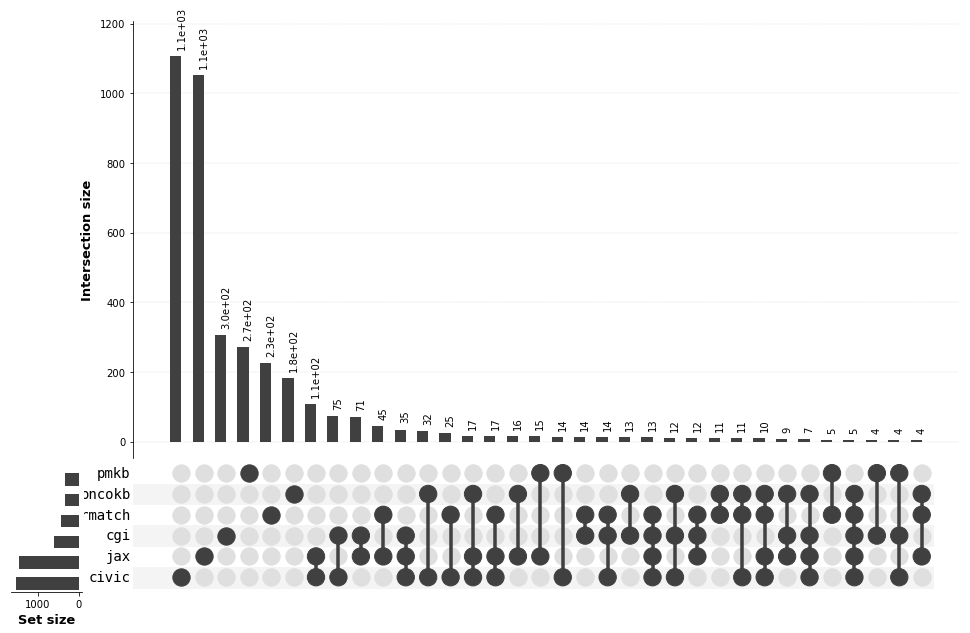

In [40]:
x = core_vdb.plot_element_by_source('publications', min_bound=4)
f = x['figure']
# f.savefig('out/publications.pdf')
x['input_data']

In [29]:
# Publications uniquely cited
data = x['input_data']
total = 0
for source in data:
    publications_from_elsewhere = set()
    for source2 in data:
        if source == source2:
            continue
        publications_from_elsewhere.update(data[source2])
    unique = data[source] - publications_from_elsewhere
    print("{}: {} resource-specific publications".format(source, len(unique)))
    total += len(unique)
print("{} ({:.2%}) total resource-specific publications".format(total, total / len(set.union(*(data.values())))))

molecularmatch: 312 resource-specific publications
civic: 1106 resource-specific publications
pmkb: 272 resource-specific publications
oncokb: 211 resource-specific publications
jax: 1311 resource-specific publications
cgi: 484 resource-specific publications
3696 (84.89%) total resource-specific publications


In [30]:
x = core_vdb.element_by_source_stats('publications')
x['ubiquitous'] # Bose et al. Cancer Discovery 2013

3696 / 4354 (84.89%) of publications are represented in only 1 resource.
203 / 4354 (4.66%) of publications are represented in the majority of (3) resources.
1 / 4354 (0.02%) of publications are represented across all resources.


{<class 'vicckb.model.Publication'>: 23220880}

### PMIDs

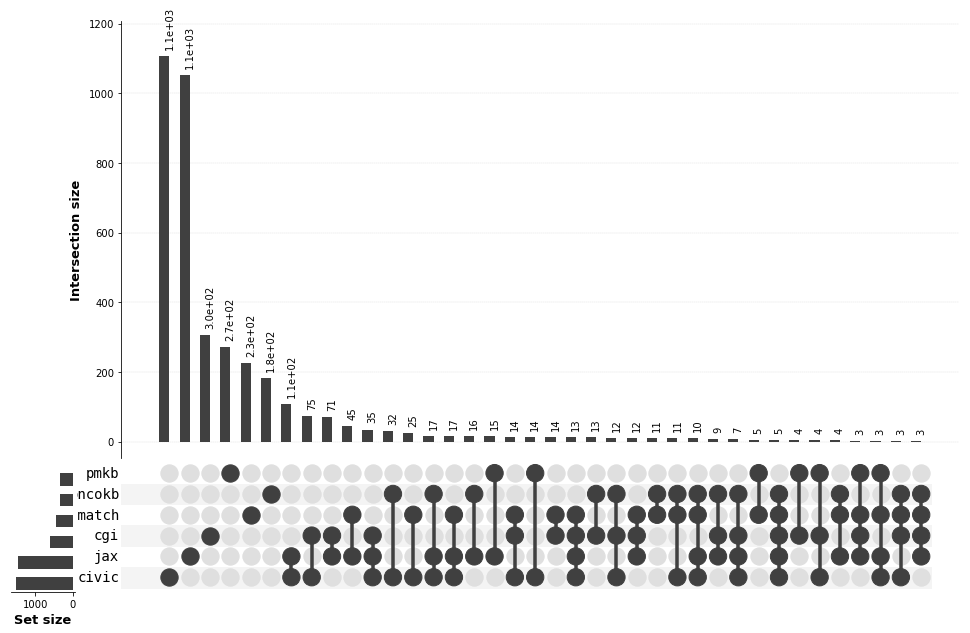

In [31]:
x = core_vdb.plot_element_by_source('publications', lambda x: x.pmid, min_bound=3)
# f = x['figure']
# f.savefig('out/pmids.pdf')

In [32]:
x = core_vdb.element_by_source_stats('publications', lambda x: x.pmid)
x['ubiquitous'] # Bose et al. Cancer Discovery 2013

3146 / 3800 (82.79%) of publications are represented in only 1 resource.
203 / 3800 (5.34%) of publications are represented in the majority of (3) resources.
1 / 3800 (0.03%) of publications are represented across all resources.


{<class 'vicckb.model.Publication'>: 23220880}

## Genes

In [33]:
no_genes = core_vdb.select(lambda x: not x.genes)
no_genes.report_groups(core_vdb)

cgi: 1 (0.1% of superset)
molecularmatch: 5 (0.2% of superset)
oncokb: 2 (0.8% of superset)
Total: 8 (0.1% of superset)


/Users/awagner/Workspace/git/vicckb/vicckb/model.py:248: UserWarning: Ambiguous gene symbol MLL2 in assertion 235677252030682
  warn('Ambiguous gene symbol {} in assertion {}'.format(g, self))


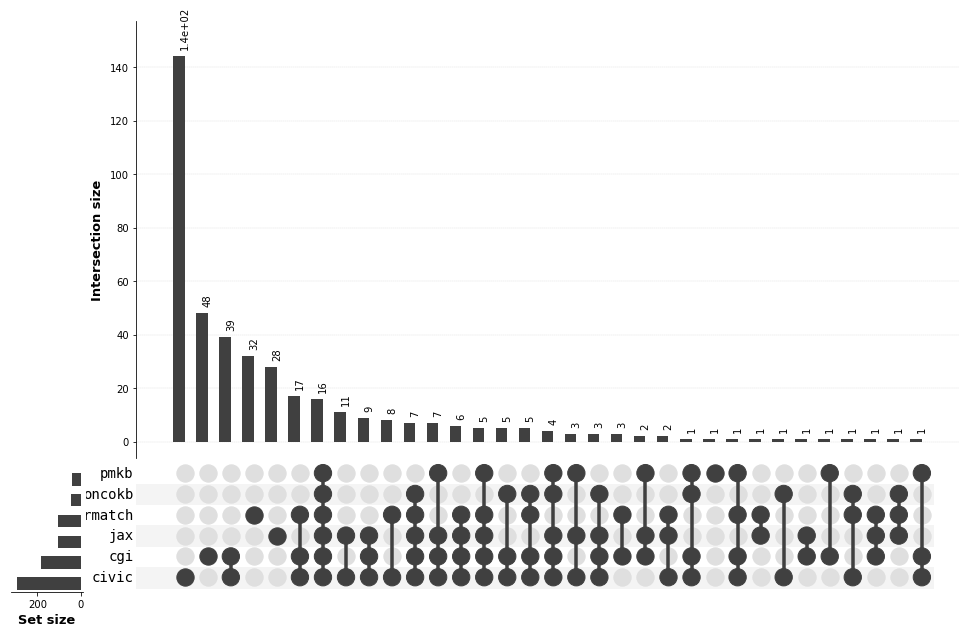

In [34]:
with_genes = core_vdb - no_genes
x = with_genes.plot_element_by_source('genes')
# f = x['figure']
# f.savefig('out/genes.pdf')

In [35]:
x = with_genes.element_by_source_stats('genes')
x['ubiquitous']

253 / 415 (60.96%) of genes are represented in only 1 resource.
97 / 415 (23.37%) of genes are represented in the majority of (3) resources.
16 / 415 (3.86%) of genes are represented across all resources.


{<class 'vicckb.model.Gene'>: EGFR,
 <class 'vicckb.model.Gene'>: ERBB2,
 <class 'vicckb.model.Gene'>: FGFR3,
 <class 'vicckb.model.Gene'>: FGFR2,
 <class 'vicckb.model.Gene'>: FLT3,
 <class 'vicckb.model.Gene'>: ALK,
 <class 'vicckb.model.Gene'>: ABL1,
 <class 'vicckb.model.Gene'>: KIT,
 <class 'vicckb.model.Gene'>: KRAS,
 <class 'vicckb.model.Gene'>: MET,
 <class 'vicckb.model.Gene'>: NOTCH1,
 <class 'vicckb.model.Gene'>: NRAS,
 <class 'vicckb.model.Gene'>: PDGFRA,
 <class 'vicckb.model.Gene'>: PIK3CA,
 <class 'vicckb.model.Gene'>: PTEN,
 <class 'vicckb.model.Gene'>: BRAF}

## Features

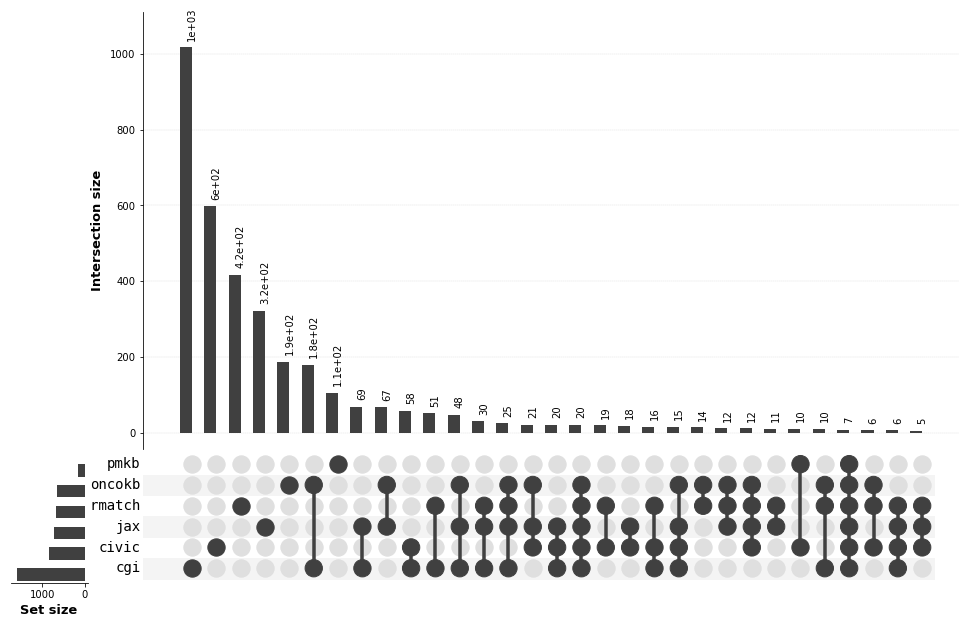

In [36]:
x = core_vdb.plot_element_by_source('features', min_bound=5)
# f = x['figure']
# f.savefig(str(FIGPATH / 'misc_figures' / 'feature_upset.pdf'))

In [37]:
x = core_vdb.element_by_source_stats('features')

2646 / 3439 (76.94%) of features are represented in only 1 resource.
279 / 3439 (8.11%) of features are represented in the majority of (3) resources.
7 / 3439 (0.20%) of features are represented across all resources.


In [38]:
ubiquitous_features = list(x['ubiquitous'])
ubiquitous_features

[<class 'vicckb.model.GenomicFeature'>: GRCh37:17:37880220:37880220:ERBB2 L755S,
 <class 'vicckb.model.GenomicFeature'>: GRCh37:7:55249071:55249071:EGFR T790M,
 <class 'vicckb.model.GenomicFeature'>: GRCh37:7:55249005:55249005:EGFR S768I,
 <class 'vicckb.model.GenomicFeature'>: GRCh37:17:37881332:37881332:ERBB2 V842I,
 <class 'vicckb.model.GenomicFeature'>: GRCh37:4:55152093:55152093:PDGFRA D842V,
 <class 'vicckb.model.GenomicFeature'>: GRCh37:7:55259515:55259515:EGFR L858R,
 <class 'vicckb.model.GenomicFeature'>: GRCh37:4:55594258:55594258:KIT V654A]

### Tier 1 variants


In [40]:
tier1 = core_vdb.select(lambda x: x.evidence_level in ['A', 'B'])
genes = set()
features = set()
for a in tier1:
    genes.update(a.genes)
    features.update(a.features)
print(len(genes))
print(len(features))

236
1499


### Hierarchical search
Existing method is to find an exact match of any features for an association. Below we demonstrate gains through hierarchical search of GenomicFeatures, a core result of this effort.

In [41]:
hits = core_vdb.search_by_feature(chromosome=7, start=140453136, end=140453136, reference_name='GRCh37')

v600k = [x['best_match']['p'] for x in hits if x['best_match']['feature'].name.endswith('V600K')]
len(v600k)

26

In [42]:
unique_features = set()
x = [x.features for x in core_vdb]
for fset in x:
    unique_features.update(fset)
unique_features = list(unique_features)
len(unique_features)

3439

In [43]:
# This is a computationally expensive operation (~1 minute for the 2800 searches). Could be sped up through indexed searching.

# feature_hits = dict()
# for feature in unique_features:
#     feature_hits[feature] = core_vdb.search_by_feature(genomic_feature=feature)

# New method

feature_hits = core_vdb.search_by_features(genomic_features=unique_features)


In [44]:
ranking = viccdb.ViccDb.MATCH_RANKING
hits_by_type = Counter()
sources_by_type = defaultdict(Counter)
for match_type in ranking:
    typed_hits = [x for x in feature_hits if ranking.index(x['best_match']['type']) <= ranking.index(match_type)]
    hits_by_type[match_type] = len(typed_hits)
    typed_associations_by_query = defaultdict(set)
    for hit in typed_hits:
        typed_associations_by_query[hit['query']].add(hit['association'])
    for associations in typed_associations_by_query.values():
        sources = {association.source for association in associations}
        sources_by_type[len(sources)][match_type] += 1
hits_by_type

Counter({'exact': 21499,
         'focal': 66242,
         'positional': 34591,
         'regional': 288441})

In [45]:
sources_by_type

defaultdict(collections.Counter,
            {1: Counter({'exact': 2387,
                      'focal': 2096,
                      'positional': 2381,
                      'regional': 493}),
             2: Counter({'exact': 461,
                      'focal': 687,
                      'positional': 610,
                      'regional': 438}),
             3: Counter({'exact': 153,
                      'focal': 302,
                      'positional': 274,
                      'regional': 757}),
             4: Counter({'exact': 55,
                      'focal': 164,
                      'positional': 110,
                      'regional': 370}),
             5: Counter({'exact': 20,
                      'focal': 115,
                      'positional': 49,
                      'regional': 928}),
             6: Counter({'exact': 7,
                      'focal': 75,
                      'positional': 15,
                      'regional': 453})})

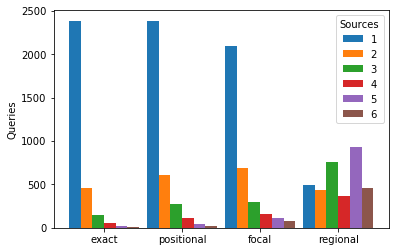

In [46]:
fig, ax = plt.subplots()

source_counts = sorted(sources_by_type)
groups = viccdb.ViccDb.MATCH_RANKING
width = 0.15
plot_elements = list()
ind = np.arange(len(groups))
for i, source_count in enumerate(source_counts):
    type_counts = sources_by_type[source_count]
    x = [type_counts[k] for k in groups]
    p = ax.bar(ind + width*(i-2.5), x, width, label=source_count)
    plot_elements.append(p)
ax.set_xticks(ind)
ax.set_xticklabels(groups)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Sources')
plt.ylabel('Queries')
plt.show()
fig.savefig('out/search_performance.pdf', format='pdf')

# Something is wrong here. Expected at least 7 positional queries to hit 6 resources.

In [47]:
# feature_hits = core_vdb.search_by_features(genomic_features=ubiquitous_features)
q = {hit['query'] for hit in feature_hits}
len(q)

3439

In [48]:
c = Counter()
for f in unique_features:
    if len(f) > 9 and len(f) < 100:
        l = '10-99'
    elif len(f) >= 100:
        l = '100+'
    else:
        l = len(f)
    c[l] += 1
c

Counter({3: 92,
         1: 2520,
         8: 5,
         5: 6,
         '100+': 506,
         '10-99': 107,
         2: 190,
         4: 7,
         6: 3,
         7: 2,
         9: 1})

### Sequence Ontology

In [49]:
count = Counter()
for association in core_vdb:
    for feature in association.features:
        count[feature.so.get('name', 'Uncategorized')] += 1

In [50]:
count.most_common(10)

[('substitution', 10176),
 ('Uncategorized', 6898),
 ('missense_variant', 2926),
 ('fusion', 2071),
 ('stop_gained', 1214),
 ('feature_amplification', 555),
 ('wild_type', 391),
 ('deletion', 264),
 ('loss_of_function_variant', 242),
 ('copy_number_loss', 207)]

In [51]:
(5052 + 3263) / sum(count.values())

0.30977572461068476

In [52]:
# Associations lacking any sequence ontology ID

def no_soid(association):
    x = [feature.so.get('name', 'Uncategorized') == 'Uncategorized' for feature in association.features]
    return all(x)

no_soid_group = core_vdb.select(no_soid)
no_soid_group.report_groups(core_vdb)

cgi: 31 (2.9% of superset)
civic: 386 (11.6% of superset)
jax: 2432 (42.3% of superset)
molecularmatch: 496 (23.8% of superset)
oncokb: 78 (31.6% of superset)
pmkb: 112 (30.2% of superset)
Total: 3535 (27.5% of superset)


In [53]:
# Associations lacking at least one sequence ontology ID

def missing_soid(association):
    x = [feature.so.get('name', 'Uncategorized') == 'Uncategorized' for feature in association.features]
    return any(x)

missing_soid_group = core_vdb.select(missing_soid)
missing_soid_group.report_groups(core_vdb)

cgi: 16 (1.5% of superset)
civic: 369 (11.0% of superset)
jax: 3197 (55.6% of superset)
molecularmatch: 480 (23.1% of superset)
oncokb: 76 (30.8% of superset)
pmkb: 108 (29.1% of superset)
Total: 4246 (33.0% of superset)


In [54]:
partial_soid_group = missing_soid_group - no_soid_group
partial_soid_group.report_groups(core_vdb)

jax: 777 (13.5% of superset)
molecularmatch: 1 (0.0% of superset)
Total: 778 (6.1% of superset)


In [55]:
partial_soid_group[0].features[2].so

{'hierarchy': ['SO:0000400', 'SO:0001761', 'SO:0001814'],
 'name': 'synonymous',
 'parent_name': 'sequence_attribute',
 'parent_soid': 'SO:0000400',
 'soid': 'SO:0001815'}

### Project GENIE feature match

In [59]:
# Loading Disease graph here for use in GENIE disease matching

import obonet
import networkx

url = 'https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/v2018-05-11/src/ontology/HumanDO.obo'
graph = obonet.read_obo(url)

assert networkx.is_directed_acyclic_graph(graph)

In [60]:
so_by_name = {
    "3'Flank": {'name': 'downstream_transcript_variant', 'soid': 'SO:0001987'},
    "3'UTR": {'name': '3_prime_UTR_variant', 'soid': 'SO:0001624'},
    "5'Flank": {'name': 'upstream_transcript_variant', 'soid': 'SO:0001986'},
    "5'UTR": {'name': '5_prime_UTR_variant', 'soid': 'SO:0001623'},
    "Frame_Shift_Del": {'name': 'frameshift_truncation', 'soid': 'SO:0001910'},
    "Frame_Shift_Ins": {'name': 'frameshift_elongation', 'soid': 'SO:0001909'},
    "In_Frame_Del": {'name': 'inframe_deletion', 'soid': 'SO:0001822'},
    "In_Frame_Ins": {'name': 'inframe_insertion', 'soid': 'SO:0001821'},
    "Intron": {'name': 'intron_variant', 'soid': 'SO:0001627'},
    "Missense_Mutation": {'name': 'missense_variant', 'soid': 'SO:0001583'},
    "Nonsense_Mutation": {'name': 'stop_gained', 'soid': 'SO:0001587'},
    "Nonstop_Mutation": {'name': 'stop_lost', 'soid': 'SO:0001578'},
    "Silent": {'name': 'synonymous_variant', 'soid': 'SO:0001819'},
    "Splice_Region": {'name': 'splice_region_variant', 'soid': 'SO:0001630'},
    "Splice_Site": {'name': 'splice_site_variant', 'soid': 'SO:0001629'},
    "Translation_Start_Site": {'name': 'initiator_codon_variant', 'soid': 'SO:0001582'}
}

In [61]:
alias_to_doids = defaultdict(list)
def map_to_doid(graph, doid):
    for _id in graph.predecessors(doid):
        map_to_doid(graph, _id)
    xrefs = graph.node[doid].get('xref', [])
    for xref in xrefs:
        source, xref_id = xref.split(':')
        alias_to_doids[(source, xref_id)].append(doid)

map_to_doid(graph, 'DOID:162') 

In [62]:
oncotree_to_aliases = dict()
oncotree_types_url = 'http://oncotree.mskcc.org/api/tumorTypes'
resp = requests.get(oncotree_types_url, params={'version': 'oncotree_2018_05_01'})
resp.raise_for_status()
oncotree_types = resp.json()
for o_type in oncotree_types:
    oncotree_to_aliases[o_type['code']] = []
    for source, terms in o_type['externalReferences'].items():
        for term in terms:
            oncotree_to_aliases[o_type['code']].append((source, term))

In [63]:
oncotree_to_doids = dict()
for o_term, aliases in oncotree_to_aliases.items():
    if not aliases:
        oncotree_to_doids[o_term] = None
        continue
    doids = set()
    for alias in aliases:
        alias_doids = alias_to_doids.get(alias, False)
        if alias_doids:
            doids.update(alias_doids)
    if doids:
        oncotree_to_doids[o_term] = list(doids)
    else:
        oncotree_to_doids[o_term] = None

In [64]:
patched_doids = {
    'MAAP': 'DOID:3608',
    'SCCNOS': 'DOID:1749',
    'MACR': 'DOID:0050861',
    'OCSC': 'DOID:0050866',
    'UDMN': 'DOID:162',
    'CUP': 'DOID:162',
    'CUPNOS': 'DOID:162',
    'MYF': 'DOID:4971',
    'HGSOC': 'DOID:0050933',
    'LGSOC': 'DOID:0050933',
    'SOC': 'DOID:0050933',
    'PANET': 'DOID:1798',
    'IMT': 'DOID:0050905',
    'OPHSC': 'DOID:0050921',
    'MDS': 'DOID:0050908',
    'ACYC': 'DOID:0080202',
    'HL': 'DOID:8567',
    'SEM': 'DOID:4440'
}

In [65]:
sample_to_patient = dict()
patient_to_samples = defaultdict(list)
sample_to_doid = dict()
required_patches = set()
optional_patches = set()
no_patch = set()

with open(DATA_ROOT / 'GENIE_v3' / 'data_clinical_sample_3.0.0.txt') as f:
    for _ in range(4):
        f.readline()    # get past info lines
    reader = csv.DictReader(f, delimiter="\t")
    for row in reader:
        patient = row['PATIENT_ID']
        sample = row['SAMPLE_ID']
        sample_to_patient[sample] = patient
        patient_to_samples[patient].append(sample)
        oncotree_code = row['ONCOTREE_CODE'].upper()
        doids = oncotree_to_doids[oncotree_code]
        if not doids:
            required_patches.add(oncotree_code)
            doid = patched_doids.get(oncotree_code, None)
        elif len(doids) > 1:
            optional_patches.add(oncotree_code)
            doid = patched_doids[oncotree_code]
        else:
            no_patch.add(oncotree_code)
            doid = doids[0]
        sample_to_doid[sample] = doid
        
patient_to_samples = dict(patient_to_samples)

In [66]:
# Load genie variants
genie_features = list()
genie_features_by_patient = defaultdict(list)
genie_features_by_variant = defaultdict(list)
with open(DATA_ROOT / 'GENIE_v3' / 'data_mutations_extended_3.0.0.txt', 'r') as maf:
    sample_list = maf.readline().strip().split(' ')[1:]
    maf_reader = csv.DictReader(maf, delimiter="\t")
    for row in maf_reader:
        start = row['Start_Position']
        end = row['End_Position']
        chromosome = row['Chromosome']
        if row['Reference_Allele'] != row['Tumor_Seq_Allele1']:
            alt = row['Tumor_Seq_Allele1']
        else:
            alt = row['Tumor_Seq_Allele2']
        reference = row['NCBI_Build']
        feature = viccdb.GenomicFeature(
            chromosome=chromosome,
            start=start,
            end=end,
            referenceName=reference,
            name=':'.join([row['Tumor_Sample_Barcode'], row['HGVSp_Short']]),
            geneSymbol=row['Hugo_Symbol'],
            sequence_ontology=so_by_name[row['Variant_Classification']],
            alt=alt
        )
        genie_features.append(feature)
        patient = sample_to_patient[row['Tumor_Sample_Barcode']]
        genie_features_by_patient[patient].append(feature)
        genie_features_by_variant[(reference, chromosome, start, end, alt)].append(feature)

In [67]:
len(genie_features)

263592

In [68]:
# Do a GENIE feature search across knowledgebase. Huge search operation takes ~5.5 min to complete
from timeit import default_timer
tick = default_timer()
genie_search_results = core_vdb.search_by_features(genie_features)
tock = default_timer()
print(tock-tick)

297.02275096898666


In [69]:
print(f'Avg. queries / second: {263592/325}')
print(f'Search results: {len(genie_search_results)}')
print(f'Avg. search results / query: {len(genie_search_results)/len(genie_features)}')

Avg. queries / second: 811.0523076923076
Search results: 2480094
Avg. search results / query: 9.408836383501775


In [70]:
genie_feature_lengths = Counter()
for feature in genie_features:
    genie_feature_lengths[len(feature)] += 1

In [198]:
result_size = defaultdict(Counter)
for result in genie_search_results:
    for match_type in ranking:
        if ranking.index(result['best_match']['type']) <= ranking.index(match_type):
            result_size[result['query']][match_type] += 1

In [151]:
print('Percentage of queries with results: {:.1%}'.format(len(result_size) / len(genie_features)))

Percentage of queries with results: 35.3%


In [165]:
exact_match_features = [x for x in result_size if result_size[x]['exact'] > 0]
len(exact_match_features)

1063

In [163]:
print('Percentage of queries with results: {:.1%}'.format(len(exact_match_features) / len(genie_features)))

Percentage of queries with results: 0.4%


In [72]:
data = defaultdict(list)
for feature in genie_features:
    length = len(feature)
    for match_type in ranking:
        data[match_type].append([length, result_size[feature][match_type]])

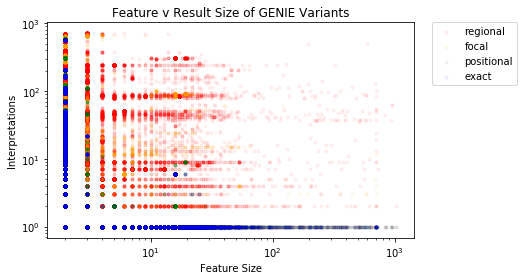

In [171]:
colors = dict(zip(ranking, ['blue', 'green', 'orange', 'red']))
pcs = list()
labels = list()
plt.figure()
plt.xscale('log')
plt.yscale('log')
for t in reversed(ranking):
    coord_pairs = data[t]
    a = np.array(coord_pairs) + 1
    pc = plt.scatter(a[:,0], a[:,1], marker='.', color=colors[t], alpha=0.05)
    pcs.append(pc)
    labels.append(t)
plt.xlabel('Feature Size')
plt.ylabel('Interpretations')
plt.title('Feature v Result Size of GENIE Variants')
plt.legend(pcs, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout() # drops legend :-/
# plt.savefig(str(FIGPATH / 'feature_v_result_size_genie.pdf'))
# plt.savefig(str(FIGPATH / 'feature_v_result_size_genie.png'))
plt.show()

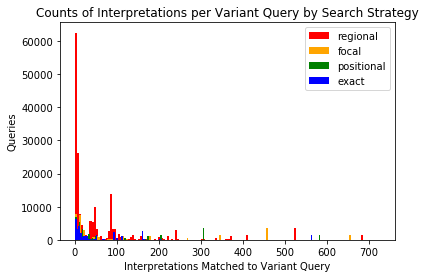

In [289]:
for t in reversed(ranking):
    data = [result_size[q][t] for q in genie_features
            if result_size[q][t] > 0
           ]
    plt.hist(data, alpha=1, label=t, color=colors[t], bins=150)
plt.xlabel('Interpretations Matched to Variant Query')
plt.ylabel('Queries')
plt.title('Counts of Interpretations per Variant Query by Search Strategy')
plt.legend()
plt.savefig(str(FIGPATH / 'genie_interpretation_v_query_all.pdf'))
plt.show()

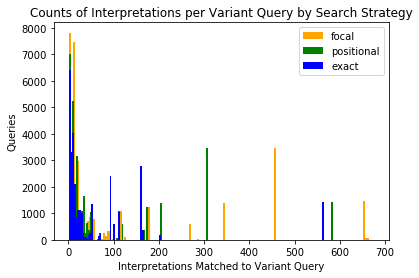

In [291]:
notables = Counter()
for t in reversed(ranking[:3]):
    data = [result_size[q][t] for q in genie_features
            if result_size[q][t] > 0
           ]
    for q in genie_features:
        if result_size[q][t] > 90:
            notables[(q,t)] += 1
    plt.hist(data, alpha=1, label=t, color=colors[t], bins=150)
plt.title('Counts of Interpretations per Variant Query by Search Strategy')
plt.xlabel('Interpretations Matched to Variant Query')
plt.ylabel('Queries')
plt.legend()
plt.savefig(str(FIGPATH / 'genie_interpretation_v_query_no_regional.pdf'))
plt.show()

In [292]:
coord_q = dict()
for notable in notables.most_common(len(notables)):
    if notable[1] > 950:
        feature = notable[0][0]
        t = notable[0][1]
        queries = notable[1]
        HGVSp = feature.name.split(':')[1]
        coord_q[(result_size[feature][t], queries)] = (feature, t)
    else:
        break
for coord in sorted(coord_q):
    feature, t = coord_q[coord]
    HGVSp = feature.name.split(':')[1]
    queries = coord[1]
    print(f'({result_size[feature][t]}, {queries}): {feature.gene_symbol} {HGVSp} ({t})')

(92, 1425): KRAS p.G12V (exact)
(94, 998): KRAS p.G12C (exact)
(111, 1062): PIK3CA p.E545K (exact)
(113, 1062): PIK3CA p.E545K (positional)
(117, 1062): PIK3CA p.E545K (focal)
(160, 1080): PIK3CA p.H1047R (exact)
(161, 1720): KRAS p.G12D (exact)
(174, 1080): PIK3CA p.H1047R (positional)
(178, 1080): PIK3CA p.H1047R (focal)
(205, 998): KRAS p.G12C (positional)
(308, 1425): KRAS p.G12V (positional)
(308, 1720): KRAS p.G12D (positional)
(343, 998): KRAS p.G12C (focal)
(457, 1425): KRAS p.G12V (focal)
(457, 1720): KRAS p.G12D (focal)
(565, 1439): BRAF p.V600E (exact)
(584, 1439): BRAF p.V600E (positional)
(655, 1439): BRAF p.V600E (focal)


## Disease

In [74]:
oncotree_codes = {x['code'] for x in oncotree_types}
print(f'There are {len(oncotree_codes)} diseases in oncotree.')
no_xrefs = {x for x, v in oncotree_to_aliases.items() if not v}
print(f'Of these, {len(no_xrefs)} have no xrefs.')
print(f'{len(required_patches)} of {len(required_patches | no_patch)} oncotree diseases from GENIE do not automatically map to doid.')
print(f'Of these, {len(required_patches & no_xrefs)} have no xrefs.')
a = np.array([
        [len(required_patches & no_xrefs), len(required_patches - no_xrefs)],
        [len(oncotree_codes & no_xrefs), len(oncotree_codes - no_xrefs)]
         ])
stats.fisher_exact(a)

There are 667 diseases in oncotree.
Of these, 166 have no xrefs.
299 of 539 oncotree diseases from GENIE do not automatically map to doid.
Of these, 123 have no xrefs.


(2.1092209748083244, 6.8296910365229976e-07)

In [75]:
c = Counter()
for x in core_vdb:
    try:
        c[x.disease.source] += 1
    except AttributeError:
        c[None] += 1
c

Counter({'http://purl.obolibrary.org/obo/doid': 12681,
         'MEDDRA': 69,
         'SNOMEDCT': 29,
         None: 1,
         'OMIM': 4,
         'DOID': 4,
         'EVS': 26,
         'ICD10CM': 3,
         'RID': 1,
         'LNC': 17,
         'ORDO': 1,
         'CL': 2,
         'PATO': 6,
         'CSP': 4,
         'menelastop.ics.upmc.fr': 1,
         'www.owl-ontologies.com': 1,
         'scai.fraunhofer.de': 1,
         'CHEBI': 1,
         'MESH': 4})

In [76]:
doid = core_vdb.select(lambda x: x.disease is not None and x.disease.id.startswith('DOID:'))

In [77]:
# Problem with number of entries from jax reporting "cancer" as doid type
doid.select(lambda x: x.disease.id == 'DOID:162').report_groups(core_vdb)

cgi: 106 (9.9% of superset)
civic: 81 (2.4% of superset)
jax: 1352 (23.5% of superset)
oncokb: 15 (6.1% of superset)
Total: 1554 (12.1% of superset)


In [78]:
id_to_name = {id_: data['name'] for id_, data in graph.nodes(data=True)}

In [79]:
c = Counter()
for x in doid:
    try:
        c[x.disease.id] += 1
    except AttributeError:
        c[None] += 1
for k, v in c.most_common(20):
    print(f'{id_to_name[k]}: {v}')

cancer: 1554
lung adenocarcinoma: 1415
breast cancer: 1089
non-small cell lung carcinoma: 1011
colorectal cancer: 976
melanoma: 659
von Hippel-Lindau disease: 566
acute myeloid leukemia: 419
rectal neoplasm: 366
chronic myeloid leukemia: 251
lung cancer: 210
gastrointestinal stromal tumor: 194
skin melanoma: 162
ovarian cancer: 156
Her2-receptor positive breast cancer: 132
stomach cancer: 122
colon cancer: 120
glioblastoma multiforme: 116
head and neck squamous cell carcinoma: 99
colorectal adenocarcinoma: 95


In [80]:
organ_system_ids = graph.predecessors('DOID:0050686')
benign_and_premalignant_ids = ['DOID:0060072', 'DOID:0060071']
cell_type_cancer_id = 'DOID:0050687'
cancer_id = 'DOID:162'

In [81]:
organ_system = dict()
benign_and_premalignant = dict()

def assign_to_id(ids, id_, d):
    if len(ids) == 0:
        return
    for i in ids:
        d[i] = id_
        assign_to_id(graph.predecessors(i), id_, d)
    return 

for organ_id in (organ_system_ids + [cell_type_cancer_id]):
    assign_to_id(graph.predecessors(organ_id), organ_id, organ_system)
    organ_system[organ_id] = organ_id

for id_ in benign_and_premalignant_ids:
    assign_to_id(graph.predecessors(id_), id_, benign_and_premalignant)
    benign_and_premalignant[id_] = id_
    


In [82]:
return_id = organ_system['DOID:0050615']
graph.node[return_id]

{'def': '"An organ system cancer located_in the respiratory system that is characterized by uncontrolled cellular proliferation in the respiratory tract." [url:http\\://en.wikipedia.org/wiki/Respiratory_tract_neoplasm]',
 'is_a': ['DOID:0050686'],
 'name': 'respiratory system cancer'}

In [83]:
normalized_disease = core_vdb.select(lambda x: x.disease is not None)
normalized_disease.report_groups(core_vdb)

cgi: 1072 (100.0% of superset)
civic: 3339 (100.0% of superset)
jax: 5746 (100.0% of superset)
molecularmatch: 2080 (100.0% of superset)
oncokb: 247 (100.0% of superset)
pmkb: 371 (100.0% of superset)
Total: 12855 (100.0% of superset)


In [84]:
do_sourced = normalized_disease.select(lambda x: x.disease.source in ['DOID', 'http://purl.obolibrary.org/obo/doid'])

In [85]:
do_sourced.report_groups(core_vdb)

cgi: 971 (90.6% of superset)
civic: 3304 (98.9% of superset)
jax: 5745 (100.0% of superset)
molecularmatch: 2080 (100.0% of superset)
oncokb: 239 (96.8% of superset)
pmkb: 346 (93.3% of superset)
Total: 12685 (98.7% of superset)


In [86]:
cancer_organ_interpretations = do_sourced.select(lambda x: organ_system.get(x.disease.id, False))
benign_premalignant_interpretations = do_sourced.select(lambda x: benign_and_premalignant.get(x.disease.id, False))
cancer_interpretations = do_sourced.select(lambda x: x.disease.id == cancer_id)
other_interpretations = do_sourced - cancer_organ_interpretations - benign_premalignant_interpretations - cancer_interpretations

In [87]:
cancer_organ_interpretations.report_groups(do_sourced)

cgi: 720 (74.2% of superset)
civic: 2602 (78.8% of superset)
jax: 4388 (76.4% of superset)
molecularmatch: 1714 (82.4% of superset)
oncokb: 213 (89.1% of superset)
pmkb: 334 (96.5% of superset)
Total: 9971 (78.6% of superset)


In [88]:
benign_premalignant_interpretations.report_groups(do_sourced)

cgi: 34 (3.5% of superset)
civic: 570 (17.3% of superset)
jax: 5 (0.1% of superset)
molecularmatch: 366 (17.6% of superset)
pmkb: 2 (0.6% of superset)
Total: 977 (7.7% of superset)


In [89]:
cancer_interpretations.report_groups(do_sourced)

cgi: 106 (10.9% of superset)
civic: 81 (2.5% of superset)
jax: 1352 (23.5% of superset)
oncokb: 15 (6.3% of superset)
Total: 1554 (12.3% of superset)


In [90]:
other_interpretations.report_groups(do_sourced)

cgi: 111 (11.4% of superset)
civic: 51 (1.5% of superset)
oncokb: 11 (4.6% of superset)
pmkb: 10 (2.9% of superset)
Total: 183 (1.4% of superset)


In [91]:
x = other_interpretations.select(lambda x: x.disease.id.split(':')[0] != 'DOID')
x.report_groups(do_sourced)

cgi: 108 (11.1% of superset)
civic: 2 (0.1% of superset)
oncokb: 2 (0.8% of superset)
pmkb: 8 (2.3% of superset)
Total: 120 (0.9% of superset)


**concerning that 10%** of CGI associations have mismatched source / terms

In [92]:
c = Counter()
for i in x:
    c[i.disease.id.split(':')[0]] += 1
c

Counter({'HP': 56, 'UBERON': 64})

In [93]:
entry = x.by_source('civic')[0]
print(entry.disease.source)
print(entry.disease.id)
print(entry.disease.term)
print(entry['feature_names'])

http://purl.obolibrary.org/obo/doid
HP:0011779
Anaplastic thyroid carcinoma
EID3744


In [94]:
c = Counter()
for association in cancer_organ_interpretations:
    disease_id = association.disease.id
    organ_id = organ_system[disease_id]
    c[organ_id] += 1

In [95]:
for k, v in c.most_common(13):
    print(f'{id_to_name[k]}: {v}')

respiratory system cancer: 2749
gastrointestinal system cancer: 1737
thoracic cancer: 1452
immune system cancer: 1338
cell type cancer: 1017
reproductive organ cancer: 487
endocrine gland cancer: 342
urinary system cancer: 231
nervous system cancer: 204
integumentary system cancer: 196
head and neck cancer: 117
musculoskeletal system cancer: 100
peritoneum cancer: 1


In [96]:
p_cancer = cancer_organ_interpretations.select(lambda x: id_to_name[organ_system[x.disease.id]] == 'peritoneum cancer')[0]
print(p_cancer.disease)
print(p_cancer.source)
print(p_cancer.description)

http://purl.obolibrary.org/obo/doid: DOID:1725
jax
In a preclinical study, the combination of APR-246 and Platinol (cisplatin) resulted in strong synergism, thereby reducing cell viability in patient derived peritoneum cancer cells harboring TP53 C135Y in culture (PMID: 27179933). 


In [97]:
len(set(organ_system.values()))

15

In [98]:
with open(DATA_ROOT / 'TopNodes_DOcancerslim_3_18.json', 'r') as f:
    result = json.load(f)
    nodes = result['graphs'][0]['nodes']

In [99]:
nodes[0]['id'].split('/')[-1].replace('_', ':')

'DOID:1324'

In [100]:
topnodes_docancerslim = list()
doid_re = re.compile(r'DOID:\d+')

for node in nodes:
    doid = node['id'].split('/')[-1].replace('_', ':')
    if doid_re.match(doid):
        topnodes_docancerslim.append(doid)

In [101]:
len(topnodes_docancerslim)

58

In [102]:
def assign_to_nearest_id(ids, id_, d, terminals):
    if len(ids) == 0:
        return
    for i in ids:
        if i in terminals:
            assignment = i
        else:
            assignment = id_
        d[i] = assignment
        assign_to_nearest_id(graph.predecessors(i), assignment, d, terminals)
    return

topnode_map = dict()
assign_to_nearest_id(['DOID:162'], 'DOID:162', topnode_map, topnodes_docancerslim)

In [103]:
cancer_counts = Counter()

cancer_associations = do_sourced.select(
    lambda x: topnode_map.get(x.disease.id, False))

for association in cancer_associations:
    disease_id = association.disease.id
    topnode_id = topnode_map[disease_id]
    cancer_counts[topnode_id] += 1

cancer_associations.report_groups(do_sourced)

cgi: 826 (85.1% of superset)
civic: 2683 (81.2% of superset)
jax: 5740 (99.9% of superset)
molecularmatch: 1714 (82.4% of superset)
oncokb: 228 (95.4% of superset)
pmkb: 334 (96.5% of superset)
Total: 11525 (90.9% of superset)


In [104]:
other_associations = do_sourced - cancer_associations
other_associations.report_groups(do_sourced)

cgi: 145 (14.9% of superset)
civic: 621 (18.8% of superset)
jax: 5 (0.1% of superset)
molecularmatch: 366 (17.6% of superset)
oncokb: 11 (4.6% of superset)
pmkb: 12 (3.5% of superset)
Total: 1160 (9.1% of superset)


In [105]:
len(cancer_counts)

48

In [106]:
for k, v in cancer_counts.most_common(48):
    print(f'{id_to_name[k]}: {v}')
    

lung cancer: 2748
cancer: 1717
breast cancer: 1452
hematologic cancer: 1324
large intestine cancer: 1073
melanoma: 661
gastrointestinal system cancer: 214
ovarian cancer: 205
skin cancer: 196
stomach cancer: 192
malignant glioma: 174
thyroid cancer: 173
pancreatic cancer: 153
colon cancer: 136
uterine cancer: 135
urinary bladder cancer: 122
prostate cancer: 121
head and neck cancer: 117
kidney cancer: 101
peripheral nervous system neoplasm: 88
ocular cancer: 56
connective tissue cancer: 52
brain cancer: 46
bone cancer: 44
bile duct cancer: 38
sarcoma: 36
esophageal cancer: 36
liver cancer: 24
cervical cancer: 16
thymus cancer: 12
meningioma: 11
adrenal gland cancer: 10
pharynx cancer: 8
salivary gland cancer: 6
endocrine gland cancer: 6
oral cavity cancer: 4
muscle cancer: 4
appendix cancer: 2
rectum cancer: 2
vulva cancer: 2
larynx cancer: 1
ureter cancer: 1
duodenum cancer: 1
penile cancer: 1
intestinal cancer: 1
peritoneum cancer: 1
vaginal cancer: 1
fallopian tube cancer: 1


In [107]:
def write_disease_counts(file_handle, disease_counter):
    writer = csv.writer(file_handle)
    s = sum(disease_counter.values())
    writer.writerow(['DOID', 'Disease Name', 'Interpretations', 'Percentage'])
    for k, v in disease_counter.most_common(len(disease_counter)):
        writer.writerow([k, id_to_name[k], v, '{:.2%}'.format(v/s)])

In [108]:
with open('out/interpretation_disease_topnode_counts.csv', 'w') as f:
    write_disease_counts(f, cancer_counts)

In [109]:
# Benign

benign_id = 'DOID:0060072'
benign = dict()

assign_to_id(graph.predecessors(benign_id), benign_id, benign)
benign[benign_id] = benign_id

benign_associations = other_associations.select(
    lambda x: benign.get(x.disease.id, False))

other_associations = other_associations - benign_associations
benign_associations.report_groups(do_sourced)

cgi: 34 (3.5% of superset)
civic: 570 (17.3% of superset)
jax: 4 (0.1% of superset)
molecularmatch: 366 (17.6% of superset)
pmkb: 2 (0.6% of superset)
Total: 976 (7.7% of superset)


In [110]:
# pre-malignant

premalignant_id = 'DOID:0060071'
premalignant = dict()

assign_to_id(graph.predecessors(premalignant_id), premalignant_id, premalignant)
premalignant[premalignant_id] = premalignant_id

premalignant_associations = other_associations.select(
    lambda x: premalignant.get(x.disease.id, False))

premalignant_associations.report_groups(do_sourced)

jax: 1 (0.0% of superset)
Total: 1 (0.0% of superset)


In [111]:
# Make data

common_cancers = list(filter(lambda x: x[0] != "DOID:162", cancer_counts.most_common(6)))

interpretation_group_names=[id_to_name[x[0]] for x in common_cancers] + ['other cancers'] + ['benign', 'other disease']
common_cancer_values = [x[1] for x in common_cancers]
interpretation_group_sizes=common_cancer_values + [sum(cancer_counts.values()) - sum(common_cancer_values),
                                      len(benign_associations),
                                      len(other_associations)]


In [112]:
incidence_by_topnode = Counter()
mortality_by_topnode = Counter()
p = (len(benign_associations) + len(other_associations)) / len(do_sourced)
with open(DATA_ROOT / 'Cancer Incidence and Mortality 2018.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        incidence_by_topnode[topnode_map[row['DOID']]] += int(row['New Cases'])
        mortality_by_topnode[topnode_map[row['DOID']]] += int(row['Estimated Deaths'])

In [113]:
def select_by_percent(counter, percent=5):
    assert percent <= 100
    s = sum(counter.values())
    out = Counter()
    for k, v in counter.most_common(len(counter)):
        if k == "DOID:162":
            continue
        p = v/s
        if p*100 < percent:
            break
        out[k] = v
        print(f'{id_to_name[k]}: {p}')
    return out

In [114]:
with open('out/NCI_disease_topnode_counts.csv', 'w') as f:
    writer = csv.writer(f)
    s1 = sum(incidence_by_topnode.values())
    s2 = sum(mortality_by_topnode.values())
    writer.writerow(
        ['DOID', 'Disease Name', 
         'Estimated New Cases, 2018, US', 'Percentage',
         'Estimated Deaths, 2018, US', 'Percentage'
        ])
    for k, v in incidence_by_topnode.most_common(len(incidence_by_topnode)):
        v2 = mortality_by_topnode[k]
        writer.writerow(
            [k, id_to_name[k], 
             v, '{:.2%}'.format(v/s1),
             v2, '{:.2%}'.format(v2/s2)
            ])

In [115]:
prevalent_incidence = select_by_percent(incidence_by_topnode)

breast cancer: 0.15482179387443457
lung cancer: 0.13486040280058778
hematologic cancer: 0.10041202062984413
prostate cancer: 0.09490304549514507
skin cancer: 0.05736594923214337
colon cancer: 0.056023280606217765


In [116]:
prevalent_mortality = select_by_percent(mortality_by_topnode)

lung cancer: 0.25269011219736237
hematologic cancer: 0.09530214552850863
colon cancer: 0.08304901253198609
pancreatic cancer: 0.07271504494455744
breast cancer: 0.0679089298602454


In [117]:
len(incidence_by_topnode)

30

In [118]:
incidence_group_names = [id_to_name[x] for x in prevalent_incidence] + ['other cancers']
incidence_group_sizes = list(prevalent_incidence.values()) + [
                            sum(incidence_by_topnode.values()) - sum(prevalent_incidence.values())
                        ]

In [119]:
mortality_group_names = [id_to_name[x] for x in prevalent_mortality] + ['other cancers']
mortality_group_sizes = list(prevalent_mortality.values()) + [
                            sum(mortality_by_topnode.values()) - sum(prevalent_mortality.values())
                        ]

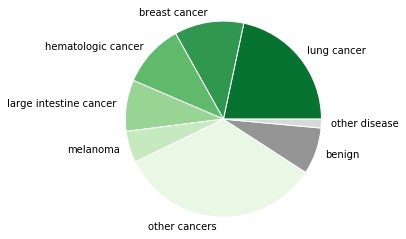

In [120]:
RADIUS=1

greens = plt.cm.Greens
grays = plt.cm.Greys
blues = plt.cm.Blues
reds = plt.cm.Reds

colors = [
    greens(.85),
    greens(.7),
    greens(.55),
    greens(.4),
    greens(.25),
    greens(.1),
    grays(.5),
    grays(.25)
]
fig1, ax1 = plt.subplots()
pie, _ = ax1.pie(interpretation_group_sizes, colors=colors, radius=RADIUS,
        labels=interpretation_group_names)
ax1.axis('equal')
plt.setp(pie, edgecolor='white')

# plt.savefig(str(FIGPATH / 'disease_interpretations.pdf'))
plt.show()

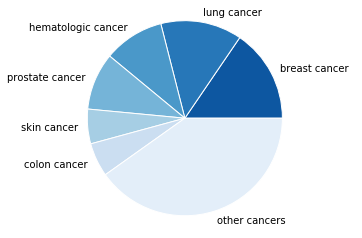

In [121]:
colors = [
    blues(.85),
    blues(.75 * 5/6 + .1),
    blues(.75 * 4/6 + .1),
    blues(.75 * 3/6 + .1),
    blues(.75 * 2/6 + .1),
    blues(.75 * 1/6 + .1),
    blues(.1)
]

fig1, ax1 = plt.subplots()
pie, _ = ax1.pie(incidence_group_sizes, colors=colors, radius=RADIUS,
        labels=incidence_group_names)

ax1.axis('equal')
plt.setp(pie, edgecolor='white')

# plt.savefig(str(FIGPATH / 'disease_incidence.pdf'))
plt.show()

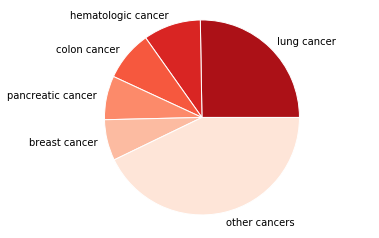

In [122]:
colors = [
    reds(.85),
    reds(.7),
    reds(.55),
    reds(.4),
    reds(.25),
    reds(.1)
]

fig1, ax1 = plt.subplots()
pie, _ = ax1.pie(mortality_group_sizes, colors=colors, radius=RADIUS,
        labels=mortality_group_names)

ax1.axis('equal')
plt.setp(pie, edgecolor='white')

# plt.savefig(str(FIGPATH / 'disease_mortality.pdf'))
plt.show()

In [123]:
b = benign_associations[0]
print(b.description)
print(b.disease)
print(b.disease.id)
print(b.source)

KRAS Q61L confers resistance to Cetuximab in patients with Neoplasm of colorectum
http://purl.obolibrary.org/obo/doid: DOID:1984
DOID:1984
molecularmatch


In [ ]:
# MAKE A DISEASE/GENE PLOT: heatmap of ubiquitous gene x disease, heat = tier 1 evidence

### Export disease counts for supplementary table

In [124]:
# d = cancer_associations.get_element_by_source('disease')
# d2 = benign_associations.get_element_by_source('disease')
d = defaultdict(Counter)
d2 = defaultdict(Counter)
for association in cancer_associations:
    disease = association.disease
    source = association.source
    d[source][disease] += 1
for association in benign_associations:
    disease = association.disease
    source = association.source
    d2[source][disease] += 1
sorted(d.keys())

['cgi', 'civic', 'jax', 'molecularmatch', 'oncokb', 'pmkb']

In [125]:
diseases = set()
cancer_diseases = set()
benign_diseases = set()
for x in d.values():
    cancer_diseases.update(x)
    diseases.update(x)
for x in d2.values():
    benign_diseases.update(x)
    diseases.update(x)

In [126]:
with open('out/disease_counts.csv', 'w') as f:
    header = ['disease', 'doid', 'TopNode_disease', 'TopNode_doid'] + sorted(d.keys())
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()
    counts = dict()
    for s, v in d.items():
        counts[s] = Counter(v)
    for s, v in d2.items():
        counts[s].update(Counter(v))
    for disease in diseases:
        if disease in cancer_diseases:
            tn_id = topnode_map[disease.id]
            tn_name = id_to_name[tn_id]
        elif disease in benign_diseases:
            tn_id = benign[disease.id]
            tn_name = id_to_name[tn_id]
        else:
            raise ValueError
        row = {
            'disease': id_to_name[disease.id],
            'doid': disease.id,
            'TopNode_disease': tn_name,
            'TopNode_doid': tn_id
        }
        for s in d:
            row[s] = counts[s][disease]
        writer.writerow(row)